In [1]:
import six

import pandas as pd
import gffutils
import pybedtools
import re
import numpy as np

v19db_filename = '/projects/ps-yeolab/genomes/hg19/gencode/v19/gencode.v19.annotation.gtf.db'
v19db = gffutils.FeatureDB(v19db_filename)

folder = '/projects/ps-yeolab/obotvinnik/singlecell_pnms'
outrigger_folder = '{}/outrigger_v2'.format(folder)


csv_folder = '/projects/ps-yeolab/obotvinnik/singlecell_pnms/csvs_for_paper'
# folder2 = '/projects/ps-yeolab2/obotvinnik/singlecell_pnm'

In [2]:
splicing_feature_folder = '{}/splicing_feature_data'.format(csv_folder)
alternative_feature_folder = '{}/alternative'.format(splicing_feature_folder)
constitutive_feature_folder = '{}/constitutive'.format(splicing_feature_folder)


Get only psi scores for events found to actually be alternative in our data (see [0.2.04_Filter_out_non-alternative_splicing_events](0.2.04_Filter_out_non-alternative_splicing_events.ipynb))

In [3]:
ll $outrigger_folder

total 26
drwxr-xr-x 5 obotvinnik 6 Dec 29 10:14 index/
drwxr-xr-x 2 obotvinnik 4 Dec 29 10:15 junctions/
drwxr-xr-x 4 obotvinnik 6 Jan  5 11:04 psi/


In [4]:
! wc -l $outrigger_folder/psi/*

wc: /projects/ps-yeolab/obotvinnik/singlecell_pnms/outrigger_v2/psi/mxe: Is a directory
         0 /projects/ps-yeolab/obotvinnik/singlecell_pnms/outrigger_v2/psi/mxe
     50070 /projects/ps-yeolab/obotvinnik/singlecell_pnms/outrigger_v2/psi/outrigger_psi.csv
wc: /projects/ps-yeolab/obotvinnik/singlecell_pnms/outrigger_v2/psi/se: Is a directory
         0 /projects/ps-yeolab/obotvinnik/singlecell_pnms/outrigger_v2/psi/se
  12567320 /projects/ps-yeolab/obotvinnik/singlecell_pnms/outrigger_v2/psi/summary_formatted.csv
  12617390 total


In [5]:
! wc -l $outrigger_folder/index/*/*

    2987610 /projects/ps-yeolab/obotvinnik/singlecell_pnms/outrigger_v2/index/gtf/gencode.v19.annotation.gtf.db
          0 /projects/ps-yeolab/obotvinnik/singlecell_pnms/outrigger_v2/index/gtf/novel_exons.gtf
     325347 /projects/ps-yeolab/obotvinnik/singlecell_pnms/outrigger_v2/index/mxe/event.bed
     325348 /projects/ps-yeolab/obotvinnik/singlecell_pnms/outrigger_v2/index/mxe/events.csv
     325347 /projects/ps-yeolab/obotvinnik/singlecell_pnms/outrigger_v2/index/mxe/exon1.bed
     325347 /projects/ps-yeolab/obotvinnik/singlecell_pnms/outrigger_v2/index/mxe/exon2.bed
     325347 /projects/ps-yeolab/obotvinnik/singlecell_pnms/outrigger_v2/index/mxe/exon3.bed
     325347 /projects/ps-yeolab/obotvinnik/singlecell_pnms/outrigger_v2/index/mxe/exon4.bed
     325347 /projects/ps-yeolab/obotvinnik/singlecell_pnms/outrigger_v2/index/mxe/intron.bed
   14621576 /projects/ps-yeolab/obotvinnik/singlecell_pnms/outrigger_v2/index/mxe/manual_metadata.csv
     325348 /projects/ps-yeolab/obotvinnik

## Use psi_alternative.csv created in [20_Filter_out_non-alternative_splicing_events](20_Filter_out_non-alternative_splicing_events.ipynb)

This has only events that were not equal to 0 or 1 in all cells

In [6]:
psi = pd.read_csv('{}/psi_alternative.csv'.format(csv_folder), index_col=0)
print(psi.shape)
psi.head()

(251, 34982)


,isoform1=junction:chr10:100189400-100190327:-|isoform2=junction:chr10:100189647-100190327:-@exon:chr10:100189548-100189646:-@junction:chr10:100189400-100189547:-,isoform1=junction:chr10:100190428-100193696:-|isoform2=junction:chr10:100191049-100193696:-@exon:chr10:100190888-100191048:-@junction:chr10:100190428-100190887:-,isoform1=junction:chr10:100193849-100195391:-|isoform2=junction:chr10:100195172-100195391:-@exon:chr10:100195029-100195171:-@junction:chr10:100193849-100195028:-,isoform1=junction:chr10:101163392-101165512:-|isoform2=junction:chr10:101163632-101165512:-@exon:chr10:101163481-101163631:-@junction:chr10:101163392-101163480:-,isoform1=junction:chr10:101191023-101193302:+|isoform2=junction:chr10:101191023-101191686:+@novel_exon:chr10:101191687-101191705:+@junction:chr10:101191706-101193302:+,isoform1=junction:chr10:101419346-101421202:+|isoform2=junction:chr10:101419346-101419618:+@exon:chr10:101419619-101419721:+@junction:chr10:101419722-101421202:+,isoform1=junction:chr10:101421386-101439481:+|isoform2=junction:chr10:101421386-101439017:+@exon:chr10:101439018-101439223:+@junction:chr10:101439224-101439481:+,isoform1=junction:chr10:101476219-101480743:-|isoform2=junction:chr10:101478258-101480743:-@exon:chr10:101478103-101478257:-@junction:chr10:101476219-101478102:-,isoform1=junction:chr10:101507148-101514285:+|isoform2=junction:chr10:101507148-101510125:+@exon:chr10:101510126-101510153:+@junction:chr10:101510154-101514285:+,isoform1=junction:chr10:101507148-101515381:+|isoform2=junction:chr10:101507148-101514285:+@exon:chr10:101514286-101514391:+@junction:chr10:101514392-101515381:+,...,isoform1=junction:chrY:14798536-14821320:+@exon:chrY:14821321-14821476:+@junction:chrY:14821477-14832521:+|isoform2=junction:chrY:14798536-14813938:+@novel_exon:chrY:14813939-14813984:+@junction:chrY:14813985-14832521:+,isoform1=junction:chrY:14802371-14820566:+@exon:chrY:14820567-14820626:+@junction:chrY:14820627-14820885:+|isoform2=junction:chrY:14802371-14813938:+@novel_exon:chrY:14813939-14813984:+@junction:chrY:14813985-14820885:+,isoform1=junction:chrY:14802371-14820566:+@exon:chrY:14820567-14820626:+@junction:chrY:14820627-14821320:+|isoform2=junction:chrY:14802371-14813938:+@novel_exon:chrY:14813939-14813984:+@junction:chrY:14813985-14821320:+,isoform1=junction:chrY:14813985-14820885:+@novel_exon:chrY:14820886-14820960:+@junction:chrY:14820961-14821320:+|isoform2=junction:chrY:14813985-14820566:+@exon:chrY:14820567-14820626:+@junction:chrY:14820627-14821320:+,isoform1=junction:chrY:14891581-14902339:+@exon:chrY:14902340-14902465:+@junction:chrY:14902466-14903431:+|isoform2=junction:chrY:14891581-14898454:+@exon:chrY:14898455-14898733:+@junction:chrY:14898734-14903431:+,isoform1=junction:chrY:15470434-15471646:-@exon:chrY:15470344-15470433:-@junction:chrY:15469850-15470343:-|isoform2=junction:chrY:15471103-15471646:-@exon:chrY:15470968-15471102:-@junction:chrY:15469850-15470967:-,isoform1=junction:chrY:16634822-16831338:+@exon:chrY:16831339-16831398:+@junction:chrY:16831399-16834996:+|isoform2=junction:chrY:16634822-16733888:+@exon:chrY:16733889-16734471:+@junction:chrY:16734472-16834996:+,isoform1=junction:chrY:21207178-21237826:-@exon:chrY:21207128-21207177:-@junction:chrY:21206582-21207127:-|isoform2=junction:chrY:21230685-21237826:-@exon:chrY:21230610-21230684:-@junction:chrY:21206582-21230609:-,isoform1=junction:chrY:21749394-21753665:+@exon:chrY:21753666-21753845:+@junction:chrY:21753846-21755284:+|isoform2=junction:chrY:21749394-21751406:+@exon:chrY:21751407-21751498:+@junction:chrY:21751499-21755284:+,isoform1=junction:chrY:21901549-21903620:-@exon:chrY:21901414-21901548:-@junction:chrY:21897637-21901413:-|isoform2=junction:chrY:21903375-21903620:-@exon:chrY:21903204-21903374:-@junction:chrY:21897637-21903203:-
CVN_01,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,0.994118,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
CVN_02,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CVN_03,NaN,NaN,NaN

In [7]:
# bed_folder = '/projects/ps-yeolab/obotvinnik/singlecell_pnms/bed'

In [8]:
# junction_exons = pd.read_csv('{}/junction_exon_triples.csv'.format(folder))
# print junction_exons.shape
# junction_exons.head()

## Get exon2 from SE and MXE events

The `splicing` matrix includes both SE and MXE events. The second exon in each of them is "exon2", or the exon which is included when Psi=1.

In [9]:
import re

In [10]:
se_event_id = 'isoform1=junction:chr10:100189400-100190327:-|isoform2=junction:chr10:100189647-100190327:-@exon:chr10:100189548-100189646:-@junction:chr10:100189400-100189547:-'
mxe_event_id = 'isoform1=junction:chrY:14802371-14820566:+@exon:chrY:14820567-14820626:+@junction:chrY:14820627-14820885:+|isoform2=junction:chrY:14802371-14813938:+@novel_exon:chrY:14813939-14813984:+@junction:chrY:14813985-14820885:+'
pattern = 'isoform2=[a-z0-9:-]@(exon[a-z0-9:-])@'

re.match(pattern, se_event_id)

In [11]:
def extract_exon(event_id):
    return event_id.split('|')[1].split('@')[1]

extract_exon(se_event_id)

'exon:chr10:100189548-100189646:-'

In [12]:
extract_exon(mxe_event_id)

'novel_exon:chrY:14813939-14813984:+'

In [13]:
import re

exon2s = pd.Series(psi.columns.map(extract_exon))
print(len(exon2s))
exon2s[:10]

34982


0          exon:chr10:100189548-100189646:-
1          exon:chr10:100190888-100191048:-
2          exon:chr10:100195029-100195171:-
3          exon:chr10:101163481-101163631:-
4    novel_exon:chr10:101191687-101191705:+
5          exon:chr10:101419619-101419721:+
6          exon:chr10:101439018-101439223:+
7          exon:chr10:101478103-101478257:-
8          exon:chr10:101510126-101510153:+
9          exon:chr10:101514286-101514391:+
dtype: object

### Write Exon2 from SE and MXE to bed file

In [14]:
from outrigger.region import Region

exon2_regions = exon2s.map(Region)

exon2_bed = pd.DataFrame.from_records(exon2_regions.map(
    lambda x: pd.Series(dict(chrom=x.chrom, start=x.start, stop=x.stop, strand=x.strand, score=1000))))

exon2_bed['name'] = psi.columns
exon2_bed = exon2_bed.reindex(columns=['chrom', 'start', 'stop', 'name', 'score', 'strand'])

print exon2_bed.shape
exon2_bed.head()

(34982, 6)


,chrom,start,stop,name,score,strand
0,chr10,100189548,100189646,isoform1=junction:chr10:100189400-100190327:-|...,1000,-
1,chr10,100190888,100191048,isoform1=junction:chr10:100190428-100193696:-|...,1000,-
2,chr10,100195029,100195171,isoform1=junction:chr10:100193849-100195391:-|...,1000,-
3,chr10,101163481,101163631,isoform1=junction:chr10:101163392-101165512:-|...,1000,-
4,chr10,101191687,101191705,isoform1=junction:chr10:101191023-101193302:+|...,1000,+


In [15]:
exon2_lengths = exon2_regions.map(len)
exon2_lengths.index = exon2_bed.name
exon2_lengths.head()

name
isoform1=junction:chr10:100189400-100190327:-|isoform2=junction:chr10:100189647-100190327:-@exon:chr10:100189548-100189646:-@junction:chr10:100189400-100189547:-           99
isoform1=junction:chr10:100190428-100193696:-|isoform2=junction:chr10:100191049-100193696:-@exon:chr10:100190888-100191048:-@junction:chr10:100190428-100190887:-          161
isoform1=junction:chr10:100193849-100195391:-|isoform2=junction:chr10:100195172-100195391:-@exon:chr10:100195029-100195171:-@junction:chr10:100193849-100195028:-          143
isoform1=junction:chr10:101163392-101165512:-|isoform2=junction:chr10:101163632-101165512:-@exon:chr10:101163481-101163631:-@junction:chr10:101163392-101163480:-          151
isoform1=junction:chr10:101191023-101193302:+|isoform2=junction:chr10:101191023-101191686:+@novel_exon:chr10:101191687-101191705:+@junction:chr10:101191706-101193302:+     19
dtype: int64

## Remove the length=1 exons from the dataset

In [16]:
length1_exons = exon2_lengths[exon2_lengths < 2]
length1_exons

name
isoform1=junction:chr2:73959413-73964428:-|isoform2=junction:chr2:73961656-73964428:-@novel_exon:chr2:73961655-73961655:-@junction:chr2:73959413-73961654:-    1
isoform1=junction:chr7:44161709-44163109:-|isoform2=junction:chr7:44161882-44163109:-@novel_exon:chr7:44161881-44161881:-@junction:chr7:44161709-44161880:-    1
isoform1=junction:chr7:44161795-44163109:-|isoform2=junction:chr7:44161882-44163109:-@novel_exon:chr7:44161881-44161881:-@junction:chr7:44161795-44161880:-    1
dtype: int64

In [17]:
psi.shape

(251, 34982)

In [18]:
psi.loc[:, exon2_lengths > 1].dropna(how='all').shape

(242, 34979)

In [19]:
psi.to_csv('{}/psi.csv'.format(csv_folder))
psi.to_csv('{}/splicing.csv'.format(csv_folder))

In [20]:
print(exon2_bed.shape)
exon2_bed = exon2_bed.query('stop > start')
print(exon2_bed.shape)

(34982, 6)
(34979, 6)


In [21]:
figure_folder = 'figures/009_constitutive_and_alternative_exons,_write_bed'
! mkdir -p $figure_folder

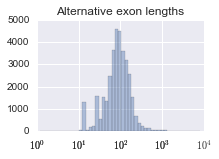

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(3, 2))
sns.distplot(np.log10(exon2_lengths), kde=False)
xticks = [int(x) for x in ax.get_xticks()]
xticklabels = ['$10^{x}$'.format(x=x) for x in xticks]
ax.set(xticks=xticks, xticklabels=xticklabels, title='Alternative exon lengths');
fig.savefig('{}/exon2_length_distribution.pdf'.format(figure_folder))

In [23]:
exon2_bed.to_csv('{}/exons.bed'.format(alternative_feature_folder), index=False, header=False, sep='\t')

## Get constitutive exons

### Use exons that are psi==1 in all celltypes

In [24]:
constutitively1 = pd.read_csv('{}/psi_constitutively1.csv'.format(csv_folder), index_col=0)
six.print_('constutitively1.shape', constutitively1.shape)
constutitively1.head()

constutitively1.shape (251, 11904)


,isoform1=junction:chr10:102013297-102020722:-|isoform2=junction:chr10:102020077-102020722:-@exon:chr10:102019975-102020076:-@junction:chr10:102013297-102019974:-,isoform1=junction:chr10:102016234-102021735:-|isoform2=junction:chr10:102020802-102021735:-@exon:chr10:102020723-102020801:-@junction:chr10:102016234-102020722:-,isoform1=junction:chr10:102703886-102706795:+|isoform2=junction:chr10:102703886-102705086:+@exon:chr10:102705087-102705263:+@junction:chr10:102705264-102706795:+,isoform1=junction:chr10:103912288-103917805:+|isoform2=junction:chr10:103912288-103916775:+@exon:chr10:103916776-103916831:+@junction:chr10:103916832-103917805:+,isoform1=junction:chr10:103912288-103919189:+|isoform2=junction:chr10:103912288-103918949:+@exon:chr10:103918950-103919065:+@junction:chr10:103919066-103919189:+,isoform1=junction:chr10:103912288-103919189:+|isoform2=junction:chr10:103912288-103918949:+@exon:chr10:103918950-103919095:+@junction:chr10:103919096-103919189:+,isoform1=junction:chr10:104111709-104113356:+|isoform2=junction:chr10:104111709-104112214:+@exon:chr10:104112215-104112275:+@junction:chr10:104112276-104113356:+,isoform1=junction:chr10:104445759-104459129:-|isoform2=junction:chr10:104449701-104459129:-@novel_exon:chr10:104449655-104449700:-@junction:chr10:104445759-104449654:-,isoform1=junction:chr10:104449701-104474029:-|isoform2=junction:chr10:104459247-104474029:-@exon:chr10:104459130-104459246:-@junction:chr10:104449701-104459129:-,isoform1=junction:chr10:104449701-104474029:-|isoform2=junction:chr10:104465247-104474029:-@exon:chr10:104465103-104465246:-@junction:chr10:104449701-104465102:-,...,isoform1=junction:chrY:14813985-14820881:+@novel_exon:chrY:14820882-14820960:+@junction:chrY:14820961-14821320:+|isoform2=junction:chrY:14813985-14820566:+@exon:chrY:14820567-14820626:+@junction:chrY:14820627-14821320:+,isoform1=junction:chrY:15024975-15026475:+@exon:chrY:15026476-15026561:+@junction:chrY:15026562-15026978:+|isoform2=junction:chrY:15024975-15025629:+@exon:chrY:15025630-15025765:+@junction:chrY:15025766-15026978:+,isoform1=junction:chrY:21094728-21206547:-@novel_exon:chrY:21094629-21094727:-@junction:chrY:21039092-21094628:-|isoform2=junction:chrY:21205233-21206547:-@exon:chrY:21205049-21205232:-@junction:chrY:21039092-21205048:-,isoform1=junction:chrY:21749394-21750428:+@exon:chrY:21750429-21750536:+@junction:chrY:21750537-21751406:+|isoform2=junction:chrY:21749394-21750255:+@novel_exon:chrY:21750256-21750297:+@junction:chrY:21750298-21751406:+,isoform1=junction:chrY:21749394-21753665:+@exon:chrY:21753666-21753845:+@junction:chrY:21753846-21755284:+|isoform2=junction:chrY:21749394-21750255:+@exon:chrY:21750256-21751498:+@junction:chrY:21751499-21755284:+,isoform1=junction:chrY:2709669-2712117:+@exon:chrY:2712118-2712298:+@junction:chrY:2712299-2713686:+|isoform2=junction:chrY:2709669-2710205:+@exon:chrY:2710206-2710283:+@junction:chrY:2710284-2713686:+,isoform1=junction:chrY:2710284-2713686:+@exon:chrY:2713687-2713784:+@junction:chrY:2713785-2722640:+|isoform2=junction:chrY:2710284-2712117:+@exon:chrY:2712118-2712298:+@junction:chrY:2712299-2722640:+,isoform1=junction:chrY:2712299-2722640:+@exon:chrY:2722641-2722812:+@junction:chrY:2722813-2733128:+|isoform2=junction:chrY:2712299-2713686:+@exon:chrY:2713687-2713784:+@junction:chrY:2713785-2733128:+,isoform1=junction:chrY:2712299-2722640:+@exon:chrY:2722641-2722812:+@junction:chrY:2722813-2734833:+|isoform2=junction:chrY:2712299-2713686:+@exon:chrY:2713687-2713784:+@junction:chrY:2713785-2734833:+,isoform1=junction:chrY:2713785-2733128:+@exon:chrY:2733129-2733286:+@junction:chrY:2733287-2734833:+|isoform2=junction:chrY:2713785-2722640:+@exon:chrY:2722641-2722812:+@junction:chrY:2722813-2734833:+
CVN_01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CVN_02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CVN_03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [25]:
# This metadata only has iPSC, NPC, and MN (no sMN)

metadata = pd.read_csv('{}/metadata.csv'.format(csv_folder), index_col=0)
metadata.head()

,single,pooled,phenotype,neuron,progenitor,stressed,craig_venter,differentiation_batch,split
CVN_01,True,False,NPC,False,True,False,True,NaN,NaN
CVN_02,True,False,NPC,False,True,False,True,NaN,NaN
CVN_03,True,False,NPC,False,True,False,True,NaN,NaN
CVN_04,True,False,NPC,False,True,False,True,NaN,NaN
CVN_05,True,False,NPC,False,True,False,True,NaN,NaN


In [26]:
counts = constutitively1.groupby(metadata.phenotype).count()
counts

,isoform1=junction:chr10:102013297-102020722:-|isoform2=junction:chr10:102020077-102020722:-@exon:chr10:102019975-102020076:-@junction:chr10:102013297-102019974:-,isoform1=junction:chr10:102016234-102021735:-|isoform2=junction:chr10:102020802-102021735:-@exon:chr10:102020723-102020801:-@junction:chr10:102016234-102020722:-,isoform1=junction:chr10:102703886-102706795:+|isoform2=junction:chr10:102703886-102705086:+@exon:chr10:102705087-102705263:+@junction:chr10:102705264-102706795:+,isoform1=junction:chr10:103912288-103917805:+|isoform2=junction:chr10:103912288-103916775:+@exon:chr10:103916776-103916831:+@junction:chr10:103916832-103917805:+,isoform1=junction:chr10:103912288-103919189:+|isoform2=junction:chr10:103912288-103918949:+@exon:chr10:103918950-103919065:+@junction:chr10:103919066-103919189:+,isoform1=junction:chr10:103912288-103919189:+|isoform2=junction:chr10:103912288-103918949:+@exon:chr10:103918950-103919095:+@junction:chr10:103919096-103919189:+,isoform1=junction:chr10:104111709-104113356:+|isoform2=junction:chr10:104111709-104112214:+@exon:chr10:104112215-104112275:+@junction:chr10:104112276-104113356:+,isoform1=junction:chr10:104445759-104459129:-|isoform2=junction:chr10:104449701-104459129:-@novel_exon:chr10:104449655-104449700:-@junction:chr10:104445759-104449654:-,isoform1=junction:chr10:104449701-104474029:-|isoform2=junction:chr10:104459247-104474029:-@exon:chr10:104459130-104459246:-@junction:chr10:104449701-104459129:-,isoform1=junction:chr10:104449701-104474029:-|isoform2=junction:chr10:104465247-104474029:-@exon:chr10:104465103-104465246:-@junction:chr10:104449701-104465102:-,...,isoform1=junction:chrY:14813985-14820881:+@novel_exon:chrY:14820882-14820960:+@junction:chrY:14820961-14821320:+|isoform2=junction:chrY:14813985-14820566:+@exon:chrY:14820567-14820626:+@junction:chrY:14820627-14821320:+,isoform1=junction:chrY:15024975-15026475:+@exon:chrY:15026476-15026561:+@junction:chrY:15026562-15026978:+|isoform2=junction:chrY:15024975-15025629:+@exon:chrY:15025630-15025765:+@junction:chrY:15025766-15026978:+,isoform1=junction:chrY:21094728-21206547:-@novel_exon:chrY:21094629-21094727:-@junction:chrY:21039092-21094628:-|isoform2=junction:chrY:21205233-21206547:-@exon:chrY:21205049-21205232:-@junction:chrY:21039092-21205048:-,isoform1=junction:chrY:21749394-21750428:+@exon:chrY:21750429-21750536:+@junction:chrY:21750537-21751406:+|isoform2=junction:chrY:21749394-21750255:+@novel_exon:chrY:21750256-21750297:+@junction:chrY:21750298-21751406:+,isoform1=junction:chrY:21749394-21753665:+@exon:chrY:21753666-21753845:+@junction:chrY:21753846-21755284:+|isoform2=junction:chrY:21749394-21750255:+@exon:chrY:21750256-21751498:+@junction:chrY:21751499-21755284:+,isoform1=junction:chrY:2709669-2712117:+@exon:chrY:2712118-2712298:+@junction:chrY:2712299-2713686:+|isoform2=junction:chrY:2709669-2710205:+@exon:chrY:2710206-2710283:+@junction:chrY:2710284-2713686:+,isoform1=junction:chrY:2710284-2713686:+@exon:chrY:2713687-2713784:+@junction:chrY:2713785-2722640:+|isoform2=junction:chrY:2710284-2712117:+@exon:chrY:2712118-2712298:+@junction:chrY:2712299-2722640:+,isoform1=junction:chrY:2712299-2722640:+@exon:chrY:2722641-2722812:+@junction:chrY:2722813-2733128:+|isoform2=junction:chrY:2712299-2713686:+@exon:chrY:2713687-2713784:+@junction:chrY:2713785-2733128:+,isoform1=junction:chrY:2712299-2722640:+@exon:chrY:2722641-2722812:+@junction:chrY:2722813-2734833:+|isoform2=junction:chrY:2712299-2713686:+@exon:chrY:2713687-2713784:+@junction:chrY:2713785-2734833:+,isoform1=junction:chrY:2713785-2733128:+@exon:chrY:2733129-2733286:+@junction:chrY:2733287-2734833:+|isoform2=junction:chrY:2713785-2722640:+@exon:chrY:2722641-2722812:+@junction:chrY:2722813-2734833:+
phenotype,,,,,,,,,,,,,,,,,,,,,
MN,2,0,3,0,4,0,4,0,2,0,...,3,1,0,0,0,0,0,0,0,0
NPC,0,1,6,1,0,1,8,0,0,0,...,2,0,0,0,1,0,0,0,0,0
iPSC,7,2,5,0,3,2,7,1,0,0,...,1,0,0,0,1,0,0,0,0,0


In [27]:
at_least_20 = (counts >= 20).all()
constitutive_events = at_least_20.index[at_least_20]

In [28]:
constitutive_exon2s = pd.Series(constitutive_events.map(lambda x: x.split('@')[1]))
constitutive_exon2s.head()

0            exon:chr11:17323291-17323417:+
1            exon:chr11:82985682-82985783:-
2          exon:chr12:121013595-121013753:+
3    novel_exon:chr12:125397183-125397280:-
4            exon:chr12:95676089-95676420:+
dtype: object

### Internal: have both downstream and upstream junctions

In [29]:
! tree $outrigger_folder

/projects/ps-yeolab/obotvinnik/singlecell_pnms/outrigger_v2
|-- index
|   |-- gtf
|   |   |-- gencode.v19.annotation.gtf.db
|   |   `-- novel_exons.gtf
|   |-- junction_exon_direction_triples.csv
|   |-- mxe
|   |   |-- event.bed
|   |   |-- events.csv
|   |   |-- exon1.bed
|   |   |-- exon2.bed
|   |   |-- exon3.bed
|   |   |-- exon4.bed
|   |   |-- intron.bed
|   |   |-- manual_metadata.csv
|   |   |-- splice_sites.csv
|   |   `-- validated
|   |       `-- events.csv
|   `-- se
|       |-- event.bed
|       |-- events.csv
|       |-- exon1.bed
|       |-- exon2.bed
|       |-- exon3.bed
|       |-- intron.bed
|       |-- manual_metadata.csv
|       |-- splice_sites.csv
|       `-- validated
|           |-- events.csv
|           `-- events.csv.bak
|-- junctions
|   |-- metadata.csv
|   `-- reads.csv
`-- psi
    |-- mxe
    |   |-- psi.csv
    |   `-- summary.csv
    |-- outrigger_psi.csv
    |-- se
    |   |-- psi.csv
    |   `-- summary.csv
    `-- summary_formatted.csv

10 director

In [30]:
junction_exons = pd.read_csv('{}/index/junction_exon_direction_triples.csv'.format(outrigger_folder))
print junction_exons.shape
junction_exons.head()

(734351, 3)


,exon,direction,junction
0,exon:chr1:29321-29370:-,upstream,junction:chr1:18367-29320:-
1,exon:chr1:29321-29370:-,upstream,junction:chr1:24892-29320:-
2,exon:chr1:24738-24891:-,downstream,junction:chr1:24892-29320:-
3,exon:chr1:24738-24891:-,upstream,junction:chr1:18062-24737:-
4,exon:chr1:24738-24891:-,upstream,junction:chr1:18367-24737:-


In [31]:
exon_direction = junction_exons.groupby(['exon', 'direction']).size()
exon_direction.head()
# constitutive = constitutive[constitutive == 2]

exon                              direction 
exon:chr10:100003848-100004106:+  downstream    1
exon:chr10:100003848-100004321:+  downstream    1
exon:chr10:100003848-100004651:+  downstream    1
exon:chr10:100003848-100004654:+  downstream    1
exon:chr10:100007447-100008748:-  downstream    1
dtype: int64

Group on the number of "direction" items they have. Must have two to be internal ("upstream" and "downstream")

In [32]:
internal_exons = exon_direction.groupby(level=0).size()
internal_exons = internal_exons[internal_exons == 2]
internal_exons.head()

exon
exon:chr10:100010822-100010933:-    2
exon:chr10:100144704-100144824:-    2
exon:chr10:100146958-100147064:-    2
exon:chr10:100155148-100155209:-    2
exon:chr10:100157102-100157255:-    2
dtype: int64

In [33]:
exon_juction_direction_internal = junction_exons.loc[junction_exons.exon.isin(internal_exons.index)]
print exon_juction_direction_internal.shape
exon_juction_direction_internal.head()

(415559, 3)


,exon,direction,junction
2,exon:chr1:24738-24891:-,downstream,junction:chr1:24892-29320:-
3,exon:chr1:24738-24891:-,upstream,junction:chr1:18062-24737:-
4,exon:chr1:24738-24891:-,upstream,junction:chr1:18367-24737:-
5,exon:chr1:24738-24891:-,upstream,junction:chr1:18380-24737:-
6,exon:chr1:24738-24891:-,upstream,junction:chr1:24440-24737:-


### Remove all exons that appear as exon2 in any alternative annotations, or exon3 for MXE

In [34]:
splicing_types = pd.Series(['MXE' if len(x.split('@')) == 5 else 'SE' for x in psi.columns], index=psi.columns)
six.print_(splicing_types.shape)
splicing_types.head()

(34982,)


isoform1=junction:chr10:100189400-100190327:-|isoform2=junction:chr10:100189647-100190327:-@exon:chr10:100189548-100189646:-@junction:chr10:100189400-100189547:-          SE
isoform1=junction:chr10:100190428-100193696:-|isoform2=junction:chr10:100191049-100193696:-@exon:chr10:100190888-100191048:-@junction:chr10:100190428-100190887:-          SE
isoform1=junction:chr10:100193849-100195391:-|isoform2=junction:chr10:100195172-100195391:-@exon:chr10:100195029-100195171:-@junction:chr10:100193849-100195028:-          SE
isoform1=junction:chr10:101163392-101165512:-|isoform2=junction:chr10:101163632-101165512:-@exon:chr10:101163481-101163631:-@junction:chr10:101163392-101163480:-          SE
isoform1=junction:chr10:101191023-101193302:+|isoform2=junction:chr10:101191023-101191686:+@novel_exon:chr10:101191687-101191705:+@junction:chr10:101191706-101193302:+    SE
dtype: object

In [35]:
mxe_exon3s = pd.Series([x.split('|')[0].split('@')[1] for x in psi.columns[splicing_types == 'MXE']])
mxe_exon3s.head()

0    exon:chr10:101996607-101996726:-
1    exon:chr10:102003455-102003534:-
2    exon:chr10:102016019-102016233:-
3    exon:chr10:102743705-102743831:-
4    exon:chr10:102743705-102743831:-
dtype: object

In [36]:
alt_exons = pd.concat([exon2s, mxe_exon3s], ignore_index=True)
print alt_exons.shape
alt_exons = alt_exons.drop_duplicates()
print alt_exons.shape

in_alt_exons = exon_juction_direction_internal.exon.isin(alt_exons.values)

constitutive = exon_juction_direction_internal.loc[(~in_alt_exons)]
print constitutive.shape
constitutive.head()

(43028,)
(23686,)
(338893, 3)


,exon,direction,junction
9,exon:chr1:17915-18061:-,downstream,junction:chr1:18062-18267:-
10,exon:chr1:17915-18061:-,downstream,junction:chr1:18062-24737:-
11,exon:chr1:17915-18061:-,upstream,junction:chr1:17056-17914:-
12,exon:chr1:17915-18061:-,upstream,junction:chr1:17743-17914:-
17,exon:chr1:16607-16765:-,downstream,junction:chr1:16766-16857:-


In [37]:
from outrigger.region import Region
constitutive_regions = pd.Series(constitutive.exon.unique()).map(Region)
print constitutive_regions.shape
constitutive_regions.head()

(129498,)


0    outrigger.Region (exon:chr1:17915-18061:-)
1    outrigger.Region (exon:chr1:16607-16765:-)
2    outrigger.Region (exon:chr1:17606-17742:-)
3    outrigger.Region (exon:chr1:17233-17368:-)
4    outrigger.Region (exon:chr1:16858-17055:-)
dtype: object

In [38]:
constitutive_junctions = constitutive.junction.unique()
len(constitutive_junctions)

209412

In [39]:
constitutive_junctions[:20]

array(['junction:chr1:18062-18267:-', 'junction:chr1:18062-24737:-',
       'junction:chr1:17056-17914:-', 'junction:chr1:17743-17914:-',
       'junction:chr1:16766-16857:-', 'junction:chr1:16028-16606:-',
       'junction:chr1:17369-17605:-', 'junction:chr1:17056-17232:-',
       'junction:chr1:29728-30563:+', 'junction:chr1:30040-30563:+',
       'junction:chr1:30668-30975:+', 'junction:chr1:92241-112699:-',
       'junction:chr1:91630-92090:-', 'junction:chr1:139848-140074:-',
       'junction:chr1:139848-142946:-', 'junction:chr1:139848-321038:-',
       'junction:chr1:139848-324445:-', 'junction:chr1:139848-670798:-',
       'junction:chr1:139848-670802:-', 'junction:chr1:139848-674209:-'], dtype=object)

### Filter constitutive junctions for usage

Check that the junctions for these exons are seen in 20+ single cells per celltype

In [40]:
! ls $csv_folder

bimodal_metadata_sequences.csv
conservation
constitutive_downstream400_pyrimidine_content.csv
constitutive_exons.bed
constitutive_feature_data.csv
constitutive_upstream400_pyrimidine_content.csv
exon2_downstream400_pyrimidine_content.csv
exon2_upstream400_pyrimidine_content.csv
expression.csv
expression_stressed.csv
junction_exon_triples.csv
junction_reads_use_multimapping.csv
mapping_stats.csv
mapping_stats_stressed.csv
metadata.csv
metadata_stressed.csv
miso_exons_names.csv
miso_ids_outrigger_calculated_psi.csv
miso_ids_outrigger_calculated_psi_unstranded.csv
miso_junction_reads2d.csv
miso_junction_reads2d_unstranded.csv
miso_junctions_invalid_mxe.csv
miso_junctions_names.csv
miso_psi_comparison_junction_reads2d.csv
mutually_exclusive_exon_consolidated_events.csv
mutually_exclusive_exons_psi.csv
mxe_events_with_stressed.csv
nucleotide_content
outrigger_output
outrigger_singlecell.sh
outrigger_singlecell.sh.err
outrigger_singlecell.sh.out
outrigger_singlecell.sh~
outrigger_v2
outrigge

In [41]:
sj = pd.read_csv('{}/sj_raw.csv'.format(csv_folder))

sj.head()

,chrom,intron_start,intron_stop,strand,intron_motif,annotated,unique_junction_reads,multimap_junction_reads,max_overhang,intron_location,sample_id
0,chr1,14830.0,14969.0,-,GT/AG,True,0.0,1.0,35.0,chr1:14830-14969:-,CVN_09
1,chr1,15039.0,15795.0,-,GT/AG,True,0.0,1.0,49.0,chr1:15039-15795:-,CVN_09
2,chr1,228777.0,237053.0,-,GT/AG,True,2.0,12.0,48.0,chr1:228777-237053:-,CVN_09
3,chr1,320654.0,324287.0,+,GT/AG,True,0.0,1.0,28.0,chr1:320654-324287:+,CVN_09
4,chr1,320939.0,321031.0,+,GT/AG,True,0.0,3.0,39.0,chr1:320939-321031:+,CVN_09


### Get just junctions associated with constitutive exons

In [42]:
sj['junction_location'] = 'junction:' + sj['intron_location']
sj.head()

,chrom,intron_start,intron_stop,strand,intron_motif,annotated,unique_junction_reads,multimap_junction_reads,max_overhang,intron_location,sample_id,junction_location
0,chr1,14830.0,14969.0,-,GT/AG,True,0.0,1.0,35.0,chr1:14830-14969:-,CVN_09,junction:chr1:14830-14969:-
1,chr1,15039.0,15795.0,-,GT/AG,True,0.0,1.0,49.0,chr1:15039-15795:-,CVN_09,junction:chr1:15039-15795:-
2,chr1,228777.0,237053.0,-,GT/AG,True,2.0,12.0,48.0,chr1:228777-237053:-,CVN_09,junction:chr1:228777-237053:-
3,chr1,320654.0,324287.0,+,GT/AG,True,0.0,1.0,28.0,chr1:320654-324287:+,CVN_09,junction:chr1:320654-324287:+
4,chr1,320939.0,321031.0,+,GT/AG,True,0.0,3.0,39.0,chr1:320939-321031:+,CVN_09,junction:chr1:320939-321031:+


In [43]:
sj_constitutive = sj.loc[sj['junction_location'].isin(constitutive_junctions)]
print sj_constitutive.shape
sj_constitutive.head()

(5579190, 12)


,chrom,intron_start,intron_stop,strand,intron_motif,annotated,unique_junction_reads,multimap_junction_reads,max_overhang,intron_location,sample_id,junction_location
2,chr1,228777.0,237053.0,-,GT/AG,True,2.0,12.0,48.0,chr1:228777-237053:-,CVN_09,junction:chr1:228777-237053:-
4,chr1,320939.0,321031.0,+,GT/AG,True,0.0,3.0,39.0,chr1:320939-321031:+,CVN_09,junction:chr1:320939-321031:+
7,chr1,566511.0,567534.0,-,GT/AG,False,0.0,24.0,43.0,chr1:566511-567534:-,CVN_09,junction:chr1:566511-567534:-
8,chr1,1309283.0,1309379.0,-,GT/AG,True,37.0,0.0,49.0,chr1:1309283-1309379:-,CVN_09,junction:chr1:1309283-1309379:-
9,chr1,1309826.0,1310084.0,-,GT/AG,True,43.0,0.0,49.0,chr1:1309826-1310084:-,CVN_09,junction:chr1:1309826-1310084:-


In [44]:
# This metadata only has iPSC, NPC, and MN (no sMN)

metadata = pd.read_csv('{}/metadata.csv'.format(csv_folder), index_col=0)
metadata.head()

,single,pooled,phenotype,neuron,progenitor,stressed,craig_venter,differentiation_batch,split
CVN_01,True,False,NPC,False,True,False,True,NaN,NaN
CVN_02,True,False,NPC,False,True,False,True,NaN,NaN
CVN_03,True,False,NPC,False,True,False,True,NaN,NaN
CVN_04,True,False,NPC,False,True,False,True,NaN,NaN
CVN_05,True,False,NPC,False,True,False,True,NaN,NaN


In [45]:
metadata.groupby('phenotype').size()

phenotype
MN      73
NPC     76
iPSC    65
dtype: int64

Get only single cells for calculating junction usage (no pooled)

In [46]:
phenotype = metadata.phenotype[metadata.single]

### Call an exon constitutive if its junction start/stop is detected in at least MIN_CELLS (10) cells per celltype

In [47]:
sj_constitutive = sj_constitutive.set_index('sample_id')
sj_constitutive = sj_constitutive.join(phenotype)
sj_constitutive.head()

,chrom,intron_start,intron_stop,strand,intron_motif,annotated,unique_junction_reads,multimap_junction_reads,max_overhang,intron_location,junction_location,phenotype
CVN_01,chr1,1328184.0,1328775.0,-,GT/AG,True,20.0,0.0,50.0,chr1:1328184-1328775:-,junction:chr1:1328184-1328775:-,NPC
CVN_01,chr1,1337637.0,1341188.0,-,GT/AG,True,362.0,0.0,50.0,chr1:1337637-1341188:-,junction:chr1:1337637-1341188:-,NPC
CVN_01,chr1,1341267.0,1342288.0,-,GT/AG,True,312.0,0.0,50.0,chr1:1341267-1342288:-,junction:chr1:1341267-1342288:-,NPC
CVN_01,chr1,1342400.0,1342510.0,-,GT/AG,True,246.0,0.0,48.0,chr1:1342400-1342510:-,junction:chr1:1342400-1342510:-,NPC
CVN_01,chr1,1572367.0,1572442.0,-,GT/AG,True,0.0,2.0,8.0,chr1:1572367-1572442:-,junction:chr1:1572367-1572442:-,NPC


### Use at least 10 unique junction reads

In [48]:
print sj_constitutive.shape
sj_constitutive = sj_constitutive.loc[sj_constitutive.unique_junction_reads >= 10]
print sj_constitutive.shape


(5579190, 12)
(4035002, 12)


In [49]:
%%time

min_samples = 10

chrom = 'chrom'
start = 'intron_start'
stop = 'intron_stop'
strand = 'strand'


constitutive_starts = sj_constitutive.groupby('phenotype').apply(
    lambda x: x.groupby([chrom, start, strand]).filter( lambda y: len(y.index.unique()) > min_samples ))
    

CPU times: user 2min 28s, sys: 9.6 s, total: 2min 37s
Wall time: 2min 38s


In [50]:
%%time 

constitutive_stops = sj_constitutive.groupby('phenotype').apply(
    lambda x: x.groupby([chrom, stop, strand]).filter(lambda y: len(y.index.unique()) > min_samples ))


CPU times: user 2min 27s, sys: 11.5 s, total: 2min 39s
Wall time: 2min 40s


### Filter for constitutive stops and starts that are in ALL phenotypes

In [51]:
constitutive_stops.groupby('phenotype').size()

phenotype
MN       507082
NPC      759328
iPSC    1253991
dtype: int64

In [52]:
%%time 
constitutive_stops_all_phenotypes = constitutive_stops.groupby('intron_location').filter(
    lambda x: len(x.groupby('phenotype')) == 3)

CPU times: user 1min 24s, sys: 291 ms, total: 1min 25s
Wall time: 1min 25s


In [53]:
%%time
constitutive_starts_all_phenotypes = constitutive_starts.groupby('intron_location').filter(
    lambda x: len(x.groupby('phenotype')) == 3)

CPU times: user 1min 25s, sys: 8.98 s, total: 1min 34s
Wall time: 1min 35s


In [54]:
constitutive_stops_all_phenotypes.head()

chrom  intron_start  intron_stop strand intron_motif  \
phenotype                                                              
MN        M1_01  chr1     1337637.0    1341188.0      -        GT/AG   
          M1_01  chr1     1341267.0    1342288.0      -        GT/AG   
          M1_01  chr1     1342400.0    1342510.0      -        GT/AG   
          M1_01  chr1     1477548.0    1479248.0      -        GT/AG   
          M1_01  chr1     1479368.0    1480242.0      -        GT/AG   

                annotated  unique_junction_reads  multimap_junction_reads  \
phenotype                                                                   
MN        M1_01      True                  588.0                      0.0   
          M1_01      True                  341.0                      0.0   
          M1_01      True                  227.0                      0.0   
          M1_01      True                  504.0                      0.0   
          M1_01      True                  421.0                      0.0   

                 max_overhang         intron_location  \
phenotype                                               
MN        M1_01          45.0  chr1:1337637-1341188:-   
          M1_01          46.0  chr1:1341267-1342288:-   
          M1_01          46.0  chr1:1342400-1342510:-   
          M1_01          45.0  chr1:1477548-1479248:-   
          M1_01          45.0  chr1:1479368-1480242:-   

                               junction_location phenotype  
phenotype                                                   
MN        M1_01  junction:chr1:1337637-1341188:-        MN  
          M1_01  junction:chr1:1341267-1342288:-        MN  
          M1_01  junction:chr1:1342400-1342510:-        MN  
          M1_01  junction:chr1:1477548-1479248:-        MN  
          M1_01  junction:chr1:1479368-1480242:-        MN

In [55]:
constitutive_upstream_junctions = constitutive_stops_all_phenotypes.junction_location.unique()
constitutive_downstream_junctions = constitutive_starts_all_phenotypes.junction_location.unique()

In [56]:
grouped = constitutive.groupby('direction')
upstream = grouped.get_group('upstream')
downstream = grouped.get_group('downstream')

Get exons which have both junctions in the list of constitutive

In [57]:
%%time
constitutive_both_junctions = constitutive.groupby('exon').filter(
    lambda x: bool(x['junction'].isin(constitutive_downstream_junctions).sum() 
                   & x['junction'].isin(constitutive_upstream_junctions).sum()))

CPU times: user 9min 40s, sys: 617 ms, total: 9min 40s
Wall time: 9min 41s


In [58]:
constitutive_both_junctions.head()

,exon,direction,junction
753,exon:chr1:1247398-1247527:-,downstream,junction:chr1:1247528-1247605:-
754,exon:chr1:1247398-1247527:-,upstream,junction:chr1:1247305-1247397:-
929,exon:chr1:1309380-1309825:-,downstream,junction:chr1:1309826-1310084:-
930,exon:chr1:1309380-1309825:-,downstream,junction:chr1:1309826-1310533:-
931,exon:chr1:1309380-1309825:-,upstream,junction:chr1:1309283-1309379:-


In [59]:
splicing_feature_folder = '{}/splicing_feature_data'.format(csv_folder)
alternative_feature_folder = '{}/alternative'.format(splicing_feature_folder)
constitutive_feature_folder = '{}/constitutive'.format(splicing_feature_folder)


In [60]:
constitutive_both_junctions.to_csv('{}/constitutive_junctions.csv'.format(constitutive_feature_folder), index=False)

In [61]:
constitutive_both_junctions.shape

(56491, 3)

In [62]:
len(constitutive_both_junctions.exon.unique())

17526

#### Make "constitutive_exons"

In [63]:
constitutive_exons = constitutive_both_junctions.exon
constitutive_exons[:10]

753     exon:chr1:1247398-1247527:-
754     exon:chr1:1247398-1247527:-
929     exon:chr1:1309380-1309825:-
930     exon:chr1:1309380-1309825:-
931     exon:chr1:1309380-1309825:-
1051    exon:chr1:1341189-1341266:-
1052    exon:chr1:1341189-1341266:-
1053    exon:chr1:1341189-1341266:-
1054    exon:chr1:1341189-1341266:-
1055    exon:chr1:1341189-1341266:-
Name: exon, dtype: object

In [64]:
constitutive_exons.shape

(56491,)

In [65]:
constitutive_exons_no_duplicates = pd.Series(constitutive_exons)
six.print_(constitutive_exons_no_duplicates.shape)
constitutive_exons_no_duplicates = constitutive_exons_no_duplicates.drop_duplicates()
six.print_(constitutive_exons_no_duplicates.shape)

(56491,)
(17526,)


### Add everything from psi_constitutively1

In [66]:
all_constitutive_exons = pd.concat([constitutive_exons_no_duplicates, constitutive_exon2s])
six.print_(all_constitutive_exons.shape)
all_constitutive_exons = all_constitutive_exons.drop_duplicates()
six.print_(all_constitutive_exons.shape)

(17567,)
(17541,)


### Make BED file of constitutive

In [67]:
Region.__len__??

In [68]:
constitutive_regions = all_constitutive_exons.map(Region)
print(len(constitutive_regions))
constitutive_regions = pd.Series([x for x in constitutive_regions if len(x) > 1])
print(len(constitutive_regions))

constitutive_bed_table = pd.DataFrame(
    map(lambda x: [x.chrom, x.start, x.stop, x.name, 1000, x.strand], constitutive_regions))
constitutive_bed_table[3] = map(lambda x: x.name, constitutive_regions)
constitutive_bed_table = constitutive_bed_table.sort_values(by=3)

constitutive_bed_table = constitutive_bed_table.drop_duplicates()
print constitutive_bed_table.shape
constitutive_bed_table.head()

17541
17540
(17540, 6)


,0,1,2,3,4,5
7874,chr10,101162337,101162479,exon:chr10:101162337-101162479:-,1000,-
7873,chr10,101163226,101163391,exon:chr10:101163226-101163391:-,1000,-
7872,chr10,101165513,101165617,exon:chr10:101165513-101165617:-,1000,-
7871,chr10,101165894,101166006,exon:chr10:101165894-101166006:-,1000,-
7870,chr10,101166483,101166606,exon:chr10:101166483-101166606:-,1000,-


In [69]:
constitutive_bed_table.to_csv('{}/exons.bed'.format(constitutive_feature_folder), sep='\t', index=False, header=False)

In [70]:
! head $constitutive_feature_folder/exons.bed

chr10	101162337	101162479	exon:chr10:101162337-101162479:-	1000	-
chr10	101163226	101163391	exon:chr10:101163226-101163391:-	1000	-
chr10	101165513	101165617	exon:chr10:101165513-101165617:-	1000	-
chr10	101165894	101166006	exon:chr10:101165894-101166006:-	1000	-
chr10	101166483	101166606	exon:chr10:101166483-101166606:-	1000	-
chr10	101180381	101180562	exon:chr10:101180381-101180562:-	1000	-
chr10	101480744	101480825	exon:chr10:101480744-101480825:-	1000	-
chr10	101483713	101483880	exon:chr10:101483713-101483880:-	1000	-
chr10	101486725	101486911	exon:chr10:101486725-101486911:-	1000	-
chr10	101487198	101487320	exon:chr10:101487198-101487320:-	1000	-


In [71]:
ls $constitutive_feature_folder

constitutive_exons_phastcons_placental_mammal.bed
constitutive_exons_phastcons_placental_mammal.txt
constitutive_junctions.csv
downstream400_placental_mammal_conservation.csv
exon2_merkin2012_ancient.csv
exon_length.csv
exons.bed
exons.fasta
exons.hg19.100way.phastCons.txt
exons_downstream200nt.bed
exons_downstream200nt_kmers.csv
exons_kmers.csv
exons_merkin2012_ancient_alt_exons.bed
exons_phastcons_placental_mammal.bed
exons_phastcons_placental_mammal.txt
exons_rnahybrid_mirbase_results.txt
exons_stop_plus1.bed
exons_upstream200_background.bed
exons_upstream200_placental_background.bed
exons_upstream200nt.bed
exons_upstream200nt_kmers.csv
first_last_internal.csv
gc_content.csv
genes.csv
genes_expanded.csv
intron_length.csv
maxentscan.csv
nucleotide_content/
phastcons_placental_mammal.txt@
repetitive_element_overlap.csv
upstream400_placental_mammal_conservation.csv
